In [1]:
import numpy as np 
import pandas as pd 

import math
import random 
import os 
import cv2
import timm

from tqdm import tqdm 

import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2

import torch 
from torch.utils.data import Dataset 
from torch import nn
import torch.nn.functional as F 

import matplotlib.pyplot as plt
import plotly.express as px

import gc
import cudf
import cuml
import cupy
from cuml.neighbors import NearestNeighbors

In [2]:
class Config:
    META_CSV = '/mnt/hdd1/wearly/deep_rec/data/5_features.csv'
    
    DATA_DIR = '/mnt/hdd1/wearly/aim_code/yolov5/data/kfashion/images/all'
    TRAIN_CSV = '/mnt/hdd1/wearly/deep_rec/data/train_csv/150limits.csv'
    TEST_CSV = '/mnt/hdd1/wearly/deep_rec/data/test_csv/150limit_test.csv'
    SEED = 123

    IMG_SIZE = 224
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]

    BATCH_SIZE = 64
    N_FOLDS = 5
    FC_DIM = 512
    
    NUM_WORKERS = 4
    DEVICE = 'cuda:1'
     
    CLASSES = 6000
    SCALE = 30 
    MARGIN = 0.5

    MODEL_NAME = 'tf_efficientnet_b4'
    MODEL_PATH = './valid_test_tf_efficientnet_b4_30_Weights/tf_efficientnet_b4_29EpochStep_adamw.pt'
    


#### Utility function

In [3]:
def read_dataset():
    df = pd.read_csv(Config.TEST_CSV,index_col=0)
    df_cu = cudf.DataFrame(df)
    image_paths = Config.DATA_DIR + '/' + df['image_name']
    return df,df_cu,image_paths

def seed_setting(seed=Config.SEED):
    random.seed(seed)
    torch.cuda.set_device(Config.DEVICE)
#     set_seed(seed, reproducible=True)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
    
seed_setting(Config.SEED)

### Dataset

In [4]:
class KfashionDataset(Dataset):
    def __init__(self, image_paths, transforms=None):

        self.image_paths = image_paths
        self.augmentations = transforms

    def __len__(self):
        return self.image_paths.shape[0]

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            augmented = self.augmentations(image=image)
            image = augmented['image']       
    
        return image,torch.tensor(1)

In [5]:
def get_test_transforms():

    return A.Compose(
        [
            A.Resize(Config.IMG_SIZE, Config.IMG_SIZE,always_apply=True),
            A.Normalize(),
        ToTensorV2(p=1.0)
        ]
    )

### Modeling

In [6]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, scale=30.0, margin=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device=Config.DEVICE)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.scale

        return output, nn.CrossEntropyLoss()(output,label)

class KfashionModel(nn.Module):

    def __init__(
        self,
        n_classes = Config.CLASSES,
        model_name = Config.MODEL_NAME,
        margin = Config.MARGIN,
        fc_dim = Config.FC_DIM,
        scale = Config.SCALE,
        use_fc = True,
        pretrained = True):


        super(KfashionModel,self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))

        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        if model_name == 'resnext50_32x4d':
            final_in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
            self.backbone.global_pool = nn.Identity()

        elif 'efficientnet' in model_name:
            final_in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.backbone.global_pool = nn.Identity()
        
        elif 'nfnet' in model_name:
            final_in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
            self.backbone.head.global_pool = nn.Identity()

        self.pooling =  nn.AdaptiveAvgPool2d(1)

        self.use_fc = use_fc

        if use_fc:
            self.dropout = nn.Dropout(p=0.0)
            self.fc = nn.Linear(final_in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_params()
            final_in_features = fc_dim

        self.final = ArcMarginProduct(
            final_in_features,
            n_classes,
            scale = scale,
            margin = margin,
            easy_margin = False,
            ls_eps = 0.0
        )

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, image, label):
        feature = self.extract_feat(image)
        #logits = self.final(feature,label)
        return feature

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        x = self.pooling(x).view(batch_size, -1)

        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)
        return x

### Image embeddings

In [12]:
def get_image_embeddings(image_paths, model_name = Config.MODEL_NAME):
    embeds = []
    
    model = KfashionModel(model_name = model_name)
    model.eval()
    
    if model_name == 'eca_nfnet_l0':
        model = replace_activations(model, torch.nn.SiLU, Mish())

    model.load_state_dict(torch.load(Config.MODEL_PATH))
    model = model.to(Config.DEVICE)
    

    image_dataset = KfashionDataset(image_paths=image_paths,transforms=get_test_transforms())
    image_loader = torch.utils.data.DataLoader(
        image_dataset,
        batch_size=Config.BATCH_SIZE,
        pin_memory=True, 
        drop_last=False,
        num_workers=4
    )
    
    
    with torch.no_grad():
        for img,label in tqdm(image_loader): 
            img = img.cuda()
            label = label.cuda()
            feat = model(img,label)
            image_embeddings = feat.detach().cpu().numpy()
            embeds.append(image_embeddings)
    
    
    del model
    image_embeddings = np.concatenate(embeds)
    print(f'Our image embeddings shape is {image_embeddings.shape}')
    del embeds
    gc.collect()
    return image_embeddings

In [13]:
%%time
df,df_cu,image_paths = read_dataset()
df.head()

CPU times: user 15.2 ms, sys: 923 µs, total: 16.1 ms
Wall time: 15.1 ms


image_name  label_group
0  country_1170781.jpg            1
1   country_353471.jpg            1
2    modern_767653.jpg            1
3    modern_347423.jpg           10
4    street_127487.jpg           10

In [14]:
image_embeddings = get_image_embeddings(image_paths)

Building Model Backbone for tf_efficientnet_b4 model


100%|██████████| 170/170 [00:20<00:00,  8.37it/s]


Our image embeddings shape is (10844, 512)


## Image predictions

In [15]:
def get_image_predictions(df, embeddings, threshold):
    
    if len(df) > 3:
        KNN = 50
    else : 
        KNN = 3
    
    model = NearestNeighbors(n_neighbors = KNN, metric = 'cosine')#cosine
    model.fit(embeddings)
    distances, indices = model.kneighbors(embeddings)
    
    predictions = []
    for k in range(embeddings.shape[0]):
        idx = np.where(distances[k,] < threshold)[0]
        ids = indices[k,idx]
        posting_ids = list(df['image_name'].iloc[ids])
        predictions.append(posting_ids)
        
    del model, distances, indices, embeddings
    gc.collect()
    
    # combine predictions(i.e. image IDs) of all the models & remove the duplicates.
    # we can try & experiment here to combine different models here..
#     predictions = [list(set(a + c)) for a, b, c in zip(predictions1, predictions2, predictions3)]
    
    return predictions

## Test prediction

In [16]:
def get_test_preds(df=df,image_embeddings=image_embeddings,threshold=0.5):
    
    #prediction after get embedding vectors
    image_pred = get_image_predictions(df,image_embeddings,threshold)
    
    result = df.copy()
    result['image_pred'] = image_pred
    result['len'] = result['image_pred'].apply(lambda x : len(x))
    
    #preds image to group label
    dict_ = dict(zip(result.image_name,result.label_group))
    result['label_pred'] = result['image_pred'].apply(lambda x : [dict_.get(y) for y in x ])
    
    return result

In [17]:
result = get_test_preds()

# Evaluation

1. 자신을 제외한 image만 남기기 (skip가능)

2. image_name to lable_group

3. metrics

In [18]:
def evaluate(df=result):

    #plotly line plot
    gf = result.len.value_counts()
    fig = px.line(gf,color_discrete_sequence=['indianred'],
                 labels = {'index' : 'numbers model predicted'},
                 title = '# pred population by threshold' )
    fig.show()
    
    #correct prediction
    p_ = []
    tot = [[df['label_group'][x]]*df.len[x] for x in range(len(df))]
    pr = df.label_pred.to_list()
    
    for i in range(len(result)):
        p_.append([a for a,b in zip(tot[i],pr[i]) if a==b]) 
    
    #calculate score
    p_len = [len(x) for x in p_]
    total_len = [len(x) for x in df.label_pred]
    score = [round((i/j)*100) for i,j in zip(p_len,total_len)]
    df['score'] = score
    
    print('=='*30)
    print(f'Mean accuracy between test groups is {np.mean(score)}')
    print('=='*30)
    
    return  df

In [19]:
df = evaluate(result)
display(df)

Mean accuracy between test groups is 65.61868314275175


image_name  label_group  \
0      country_1170781.jpg            1   
1       country_353471.jpg            1   
2        modern_767653.jpg            1   
3        modern_347423.jpg           10   
4        street_127487.jpg           10   
...                    ...          ...   
10839    street_940544.jpg         5990   
10840   country_795303.jpg         5990   
10841    street_847806.jpg         5990   
10842    street_932010.jpg         5990   
10843    sporty_189380.jpg         5990   

                                              image_pred  len  \
0                                  [country_1170781.jpg]    1   
1      [country_353471.jpg, street_771457.jpg, sophis...    4   
2      [modern_767653.jpg, modern_770150.jpg, street_...    3   
3      [modern_347423.jpg, genderless_788253.jpg, str...    3   
4                                    [street_127487.jpg]    1   
...                                                  ...  ...   
10839  [street_940544.jpg, street_932010.jpg, street_...    3   
10840            [country_795303.jpg, street_811735.jpg]    2   
10841             [street_847806.jpg, street_848229.jpg]    2   
10842             [street_932010.jpg, street_940544.jpg]    2   
10843  [sporty_189380.jpg, genderless_1224090.jpg, st...    3   

               label_pred  score  
0                     [1]    100  
1      [1, 211, 298, 211]     25  
2           [1, 211, 211]     33  
3          [10, 10, 3867]     67  
4                    [10]    100  
...                   ...    ...  
10839  [5990, 5990, 5990]    100  
10840        [5990, 4051]     50  
10841        [5990, 5216]     50  
10842        [5990, 5990]    100  
10843  [5990, 5989, 3898]     33  

[10844 rows x 6 columns]

In [20]:
class visual_kfashion:
    def visualize(df, path, matrix_num, idx_num):
        '''
        matrix_num : 2로 설정할경우 2*2 행렬로 총 4개 출력
        label_num : 보고싶은 인덱스 
        '''
        smp_dt = df.iloc[idx_num , -4]
        print()
        print(f'{idx_num}번째 인덱스의 이미지 그룹 수는 총 {len(smp_dt)}장 입니다.')
        fig = plt.figure(figsize=(20, 20))
        rows = matrix_num
        cols = matrix_num
        i = 1
        
        for filename in smp_dt:
            try:
                plt.rcParams["font.family"] = 'NanumGothicCoding'
                img = cv2.imread(f'{path}/{filename}')
                ax = fig.add_subplot(rows, cols, i)
                ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                cat = md.loc[md.image_name==filename, "sub_category"].values
                color = md.loc[md.image_name==filename, "color"].values
                pt = md.loc[md.image_name==filename, "print"].values
                fit = md.loc[md.image_name==filename, "fit"].values
                
                ax.set_xlabel(f" {filename} \n category:{cat} \n color:{color} \n print:{pt} \n fit:{fit}")
                ax.set_xticks([]), ax.set_yticks([])
                i += 1
            except:
                break

In [21]:
md = pd.read_csv(Config.META_CSV,index_col=0)
md.head()

/home/user/anaconda3/envs/rapids-0.18/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



image_name sub_category main_style color print  fit
0  feminine_1204621.jpg          드레스   feminine   베이지    무지  타이트
1   romantic_292213.jpg          스커트   romantic   화이트   플로럴   루즈
2   romantic_987357.jpg         블라우스   romantic    와인    체크   루즈
3   romantic_987357.jpg          스커트   romantic   화이트    무지  스키니
4  feminine_1099505.jpg          드레스   feminine    블랙    체크   노멀

In [39]:
result[result.len==20].head()

image_name  label_group  \
160    country_216063.jpg          121   
2253   classic_917928.jpg         1257   
2340    street_269452.jpg         1325   
2399  romantic_180657.jpg         1350   
2956    feminine_1548.jpg         1769   

                                             image_pred  len  \
160   [country_216063.jpg, modern_1284889.jpg, moder...   20   
2253  [classic_917928.jpg, classic_917945.jpg, femin...   20   
2340  [street_269452.jpg, street_471146.jpg, street_...   20   
2399  [romantic_180657.jpg, street_1254521.jpg, reso...   20   
2956  [feminine_1548.jpg, resort_1120752.jpg, sophis...   20   

                                             label_pred  score  
160   [121, 972, 972, 972, 972, 419, 972, 3089, 970,...      5  
2253  [1257, 1257, 1350, 1257, 1257, 1349, 1256, 125...     30  
2340  [1325, 1325, 1325, 1324, 1326, 1325, 1325, 110...     30  
2399  [1350, 1349, 1349, 1325, 910, 911, 1350, 882, ...     20  
2956  [1769, 4343, 1769, 1769, 1769, 1769, 4342, 478...     45


2340번째 인덱스의 이미지 그룹 수는 총 20장 입니다.


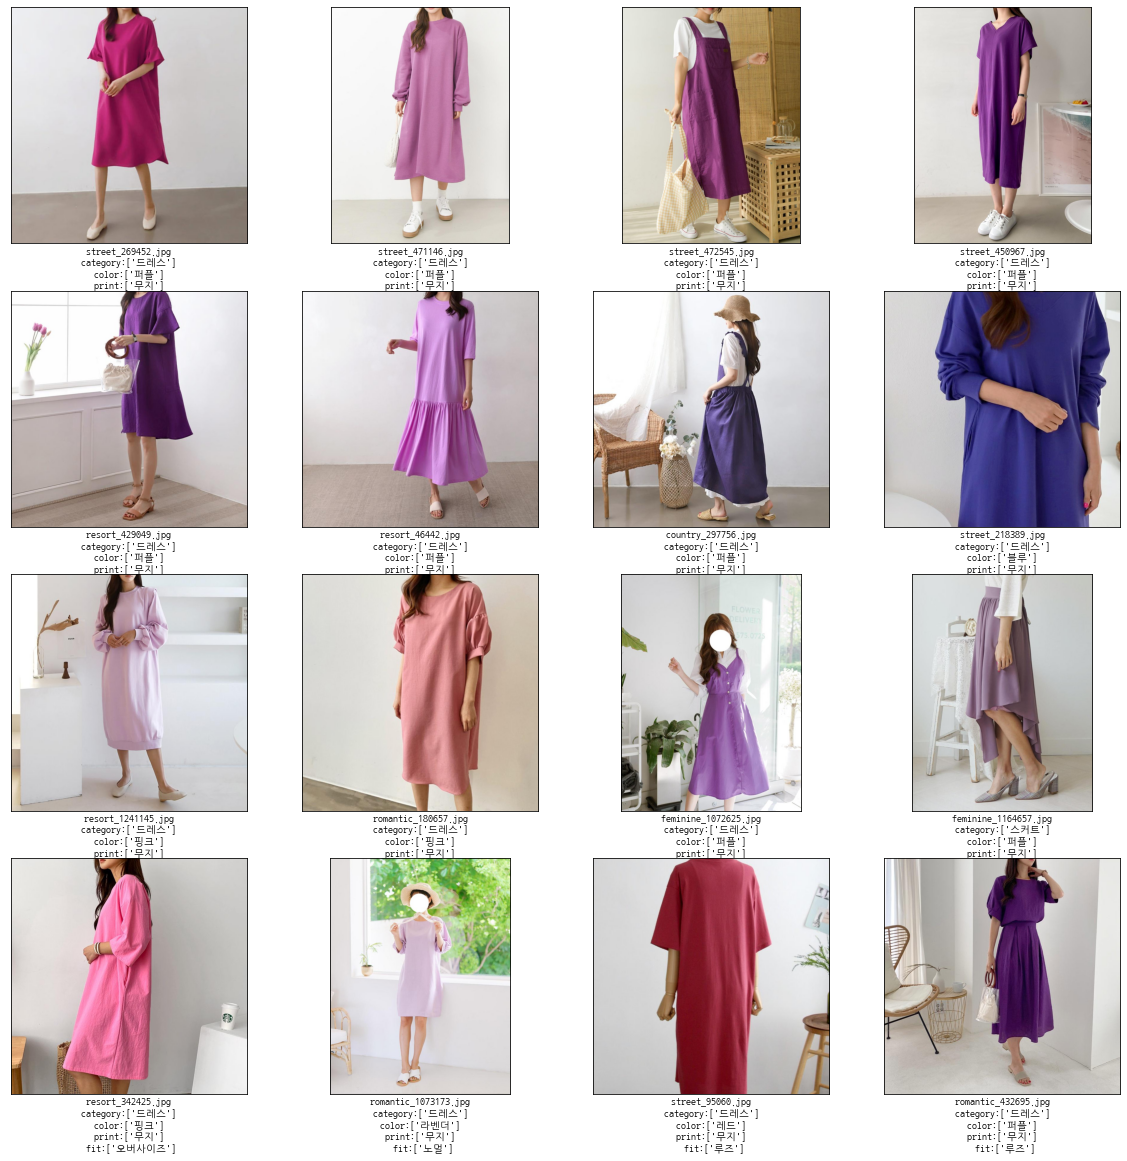

In [41]:
path = '/mnt/hdd1/wearly/aim_code/yolov5/data/kfashion/images/all'
visual_kfashion.visualize(df=df, path=path, matrix_num=4, idx_num=2340)


20번째 인덱스의 이미지 그룹 수는 총 1장 입니다.


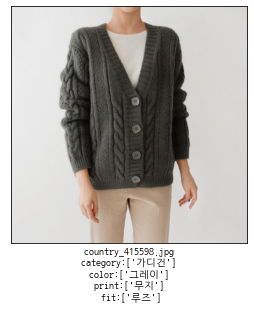

In [42]:
path = '/mnt/hdd1/wearly/aim_code/yolov5/data/kfashion/images/all'
visual_kfashion.visualize(df=df, path=path, matrix_num=4, idx_num=20)


84번째 인덱스의 이미지 그룹 수는 총 8장 입니다.


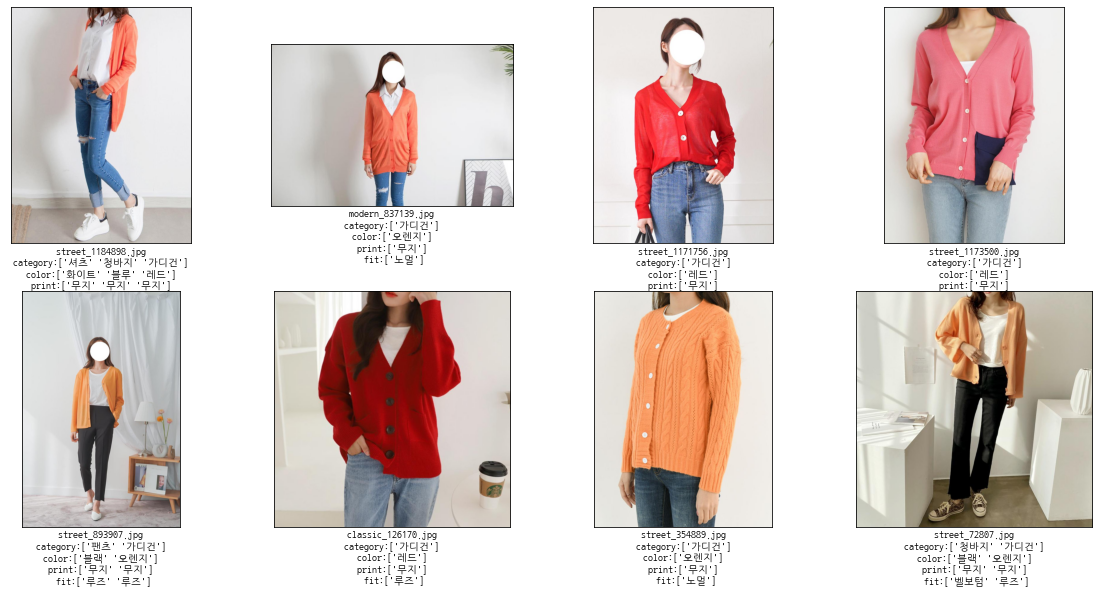

In [30]:
path = '/mnt/hdd1/wearly/aim_code/yolov5/data/kfashion/images/all'
visual_kfashion.visualize(df=df, path=path, matrix_num=4, idx_num=84)

### Experiment

In [43]:
def evaluate_score(df=result):
    
    #correct prediction
    p_ = []
    tot = [[df['label_group'][x]]*df.len[x] for x in range(len(df))]
    pr = df.label_pred.to_list()
    
    for i in range(len(result)):
        p_.append([a for a,b in zip(tot[i],pr[i]) if a==b]) 
    
    #calculate score
    p_len = [len(x) for x in p_]
    total_len = [len(x) for x in df.label_pred]
    score = [round((i/j)*100) for i,j in zip(p_len,total_len)]
    
    
    return np.mean(score)

In [44]:
for threshold in np.arange(0.2,0.7,0.05):
    pred = get_test_preds(threshold=threshold)
    score = evaluate_score(df=pred)
    
    print(f'Mean prediction scores for threshold {threshold} : {score}')

Mean prediction scores for threshold 0.2 : 96.31049428255257
Mean prediction scores for threshold 0.25 : 94.49483585392844
Mean prediction scores for threshold 0.3 : 91.92511988196237
Mean prediction scores for threshold 0.35 : 88.33327185540391
Mean prediction scores for threshold 0.39999999999999997 : 82.9710438952416
Mean prediction scores for threshold 0.44999999999999996 : 75.70481372187385
Mean prediction scores for threshold 0.49999999999999994 : 65.61868314275175
Mean prediction scores for threshold 0.5499999999999999 : 53.30154924382147
Mean prediction scores for threshold 0.5999999999999999 : 40.02314644042789
Mean prediction scores for threshold 0.6499999999999999 : 27.533105864994468
